In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# set up notebook
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from pathlib import Path
import itertools
import warnings

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss




warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})

# import stationary_check
import stationary_check

In [3]:
# path for dataset
comp_dir = Path(r'D:\Python(New)\Project\Store_Sales_Time_Series_Forecasting\data')
# load data
train = pd.read_csv(comp_dir / 'train.csv',index_col = False)
test = pd.read_csv(comp_dir / 'test.csv',index_col = False)

In [12]:
# run this code to load dataset and run code on GoogleColab
#from google.colab import files
 
 
#uploaded = files.upload()

In [13]:
# for GoogloColab
#train = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv")

## Time Series Forecasting

In [14]:
# run this code to load dataset and run code on GoogleColab
#from google.colab import files

#uploaded = files.upload()

In [4]:
# change date column to datetime
train['date'] = pd.to_datetime(train['date'])
# create year and month column
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month

In [5]:
# data
time_series = train.groupby(['date'])['sales'].sum().reset_index().rename(columns={'sum':'sales'})
time_series = time_series.set_index('date')
time_series.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


In [6]:
# set target
sales_weekly = time_series['sales'].resample('MS').mean()
sales_weekly.head()


date
2013-01-01    333149.185062
2013-02-01    344962.849194
2013-03-01    368661.194758
2013-04-01    366448.824600
2013-05-01    374119.484098
Freq: MS, Name: sales, dtype: float64

## Decomposing the Time Series-trend, seasonality, and noise

In [7]:
# check stationary of data
stationary_check.ADF_Stationarity_Test(sales_weekly)

ADF Statistic: -1.574664
p-value: 0.496307
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596
The time series is likely non-stationary. 0.05


In [19]:
# apply log transformation and first difference
#sales_weekly_log = np.log(sales_weekly)
#sales_weekly_log_diff = sales_weekly_log - sales_weekly_log.shift()
#stationary_check.ADF_Stationarity_Test(sales_weekly_log_diff.dropna())

ADF Statistic: -4.444704
p-value: 0.000247
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
The time series is likely stationary. 0.05


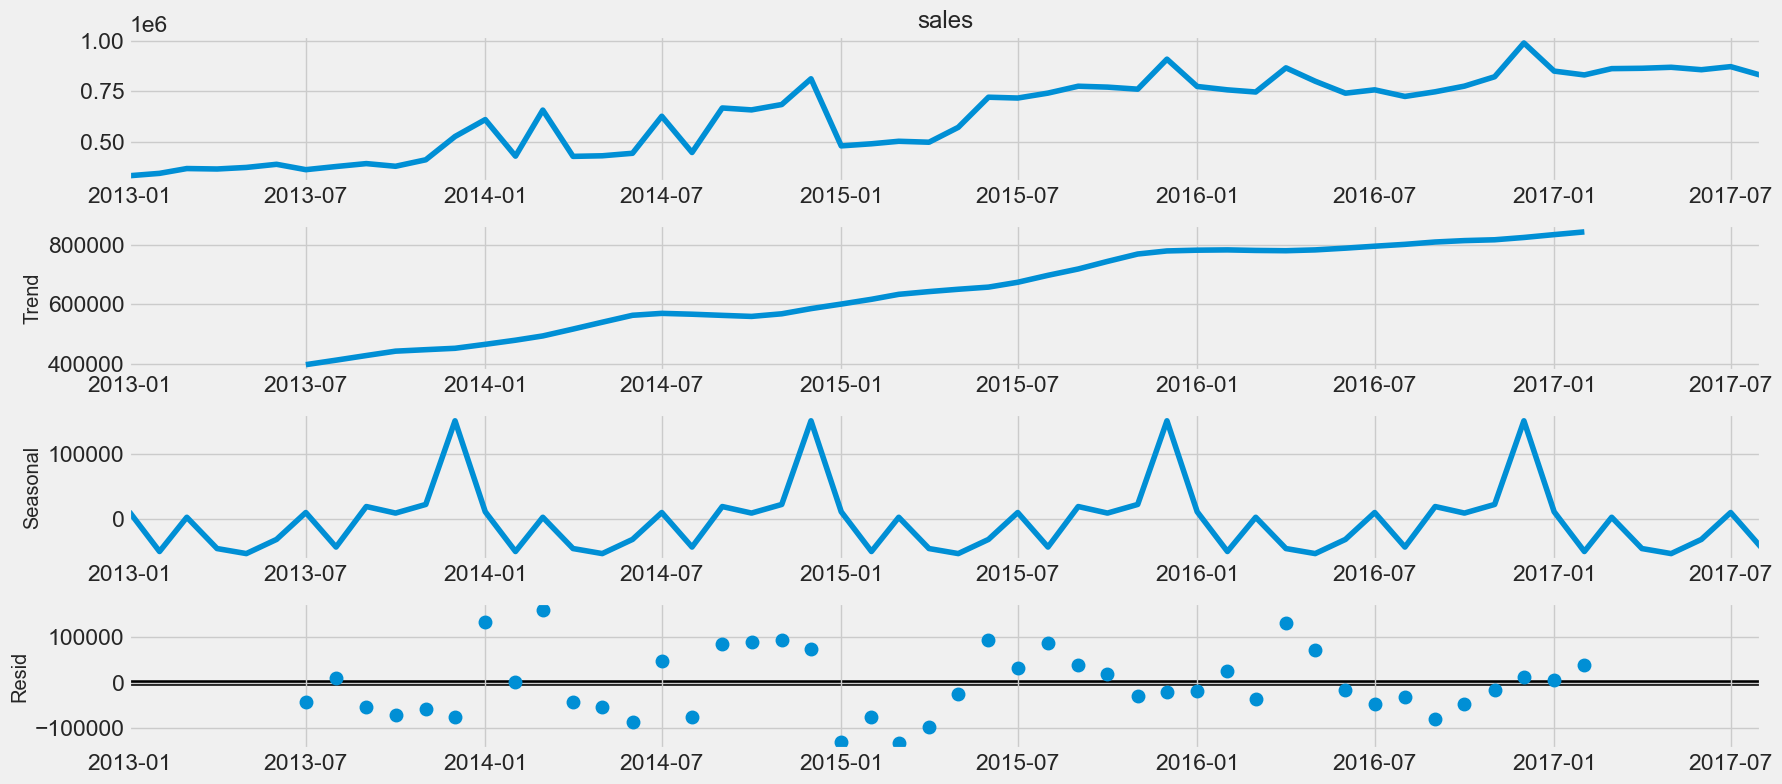

In [8]:
# decomposing the time series
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sales_weekly, model='additive')
fig = decomposition.plot()
plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\decomposition.png")
plt.show()

## ARIMA(Seasonal ARIMA) Model

In [9]:
# define the d and q parameters to take any value between 0 and 1
d = q = range(0, 2)

# define the p parameters to take any value between 0 and 3
p = range(0, 4)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
# split data
train_data = sales_weekly[:2017]
test_data = sales_weekly[2017:]

In [12]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [13]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 114.80132591665787 for model SARIMAX(3, 1, 0)x(3, 1, 0, 12)


In [14]:
# fit the model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_invertibility=False)

results = mod.fit()

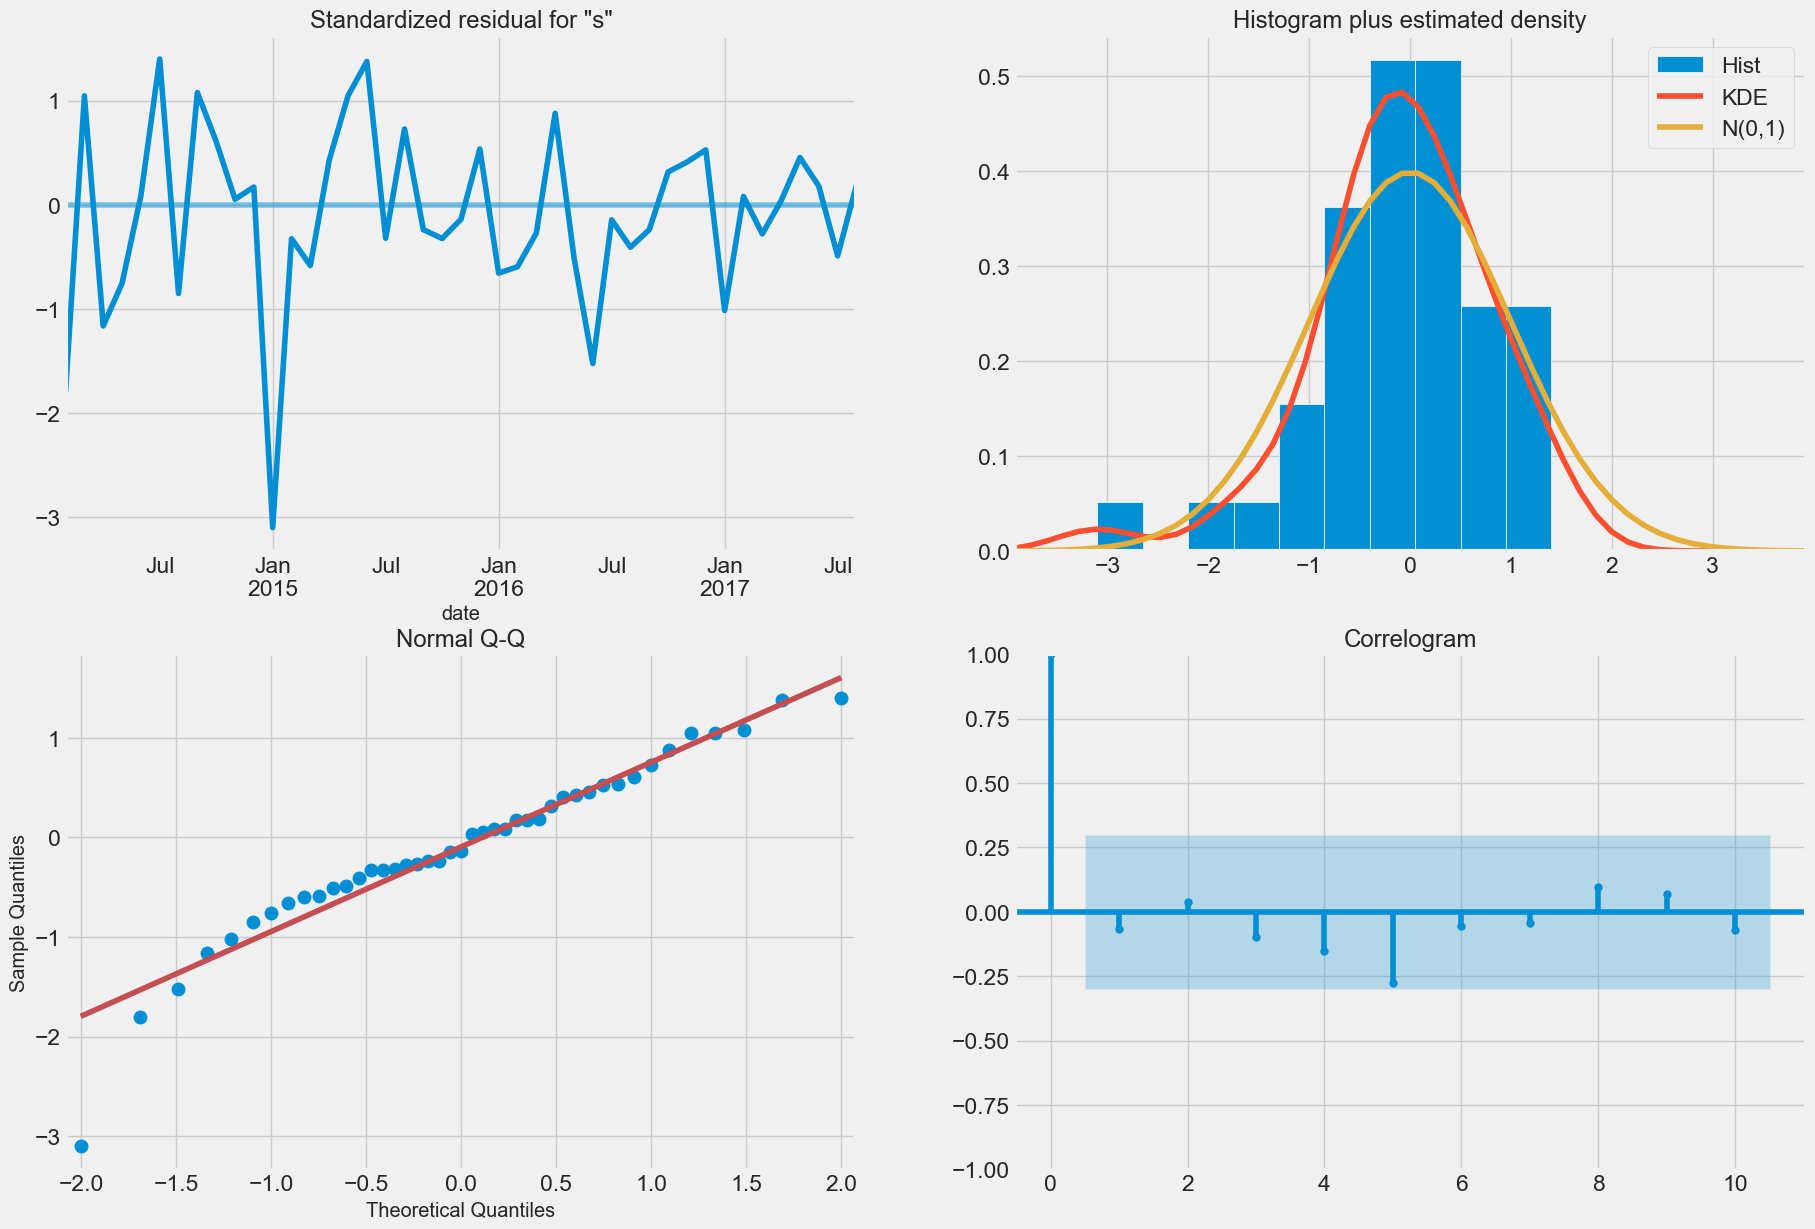

In [15]:
results.plot_diagnostics(figsize=(20, 14))
plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\diagnostics.png")
plt.show()

### Validating Forecasts

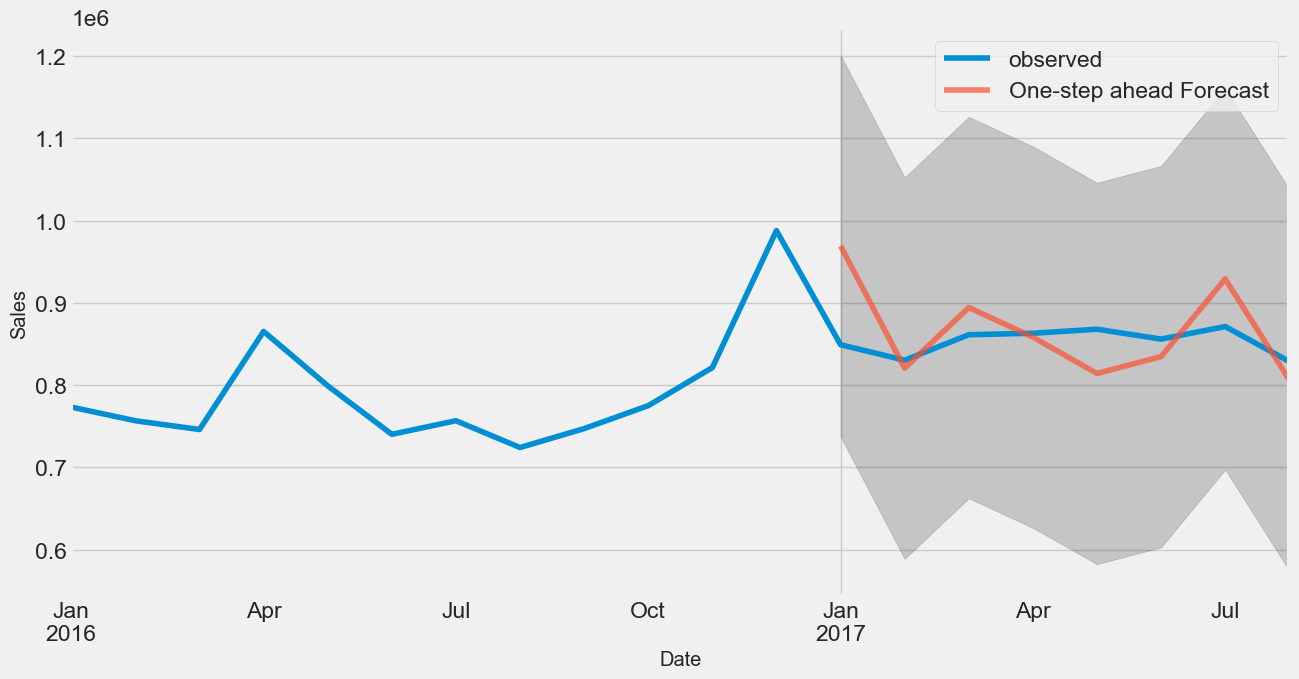

In [17]:
pred0 = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred0_ci = pred0.conf_int()

# visualize the prediction
ax = sales_weekly['2016':].plot(label='observed')
pred0.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred0_ci.index,
                pred0_ci.iloc[:, 0],
                pred0_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\prediction.png")
plt.show()

In [18]:
# one-step ahead prediction with dynamic forecast
pred1 = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True)
pred1_ci = pred1.conf_int()
# "True" forecast
pred2 = results.get_forecast(steps=12)
pred2_ci = pred2.conf_int()
print(round(pred2.predicted_mean['2017-01-01':'2017-12-01'],2))


2017-09-01     913666.27
2017-10-01     933177.81
2017-11-01     962863.03
2017-12-01    1111968.84
Freq: MS, Name: predicted_mean, dtype: float64


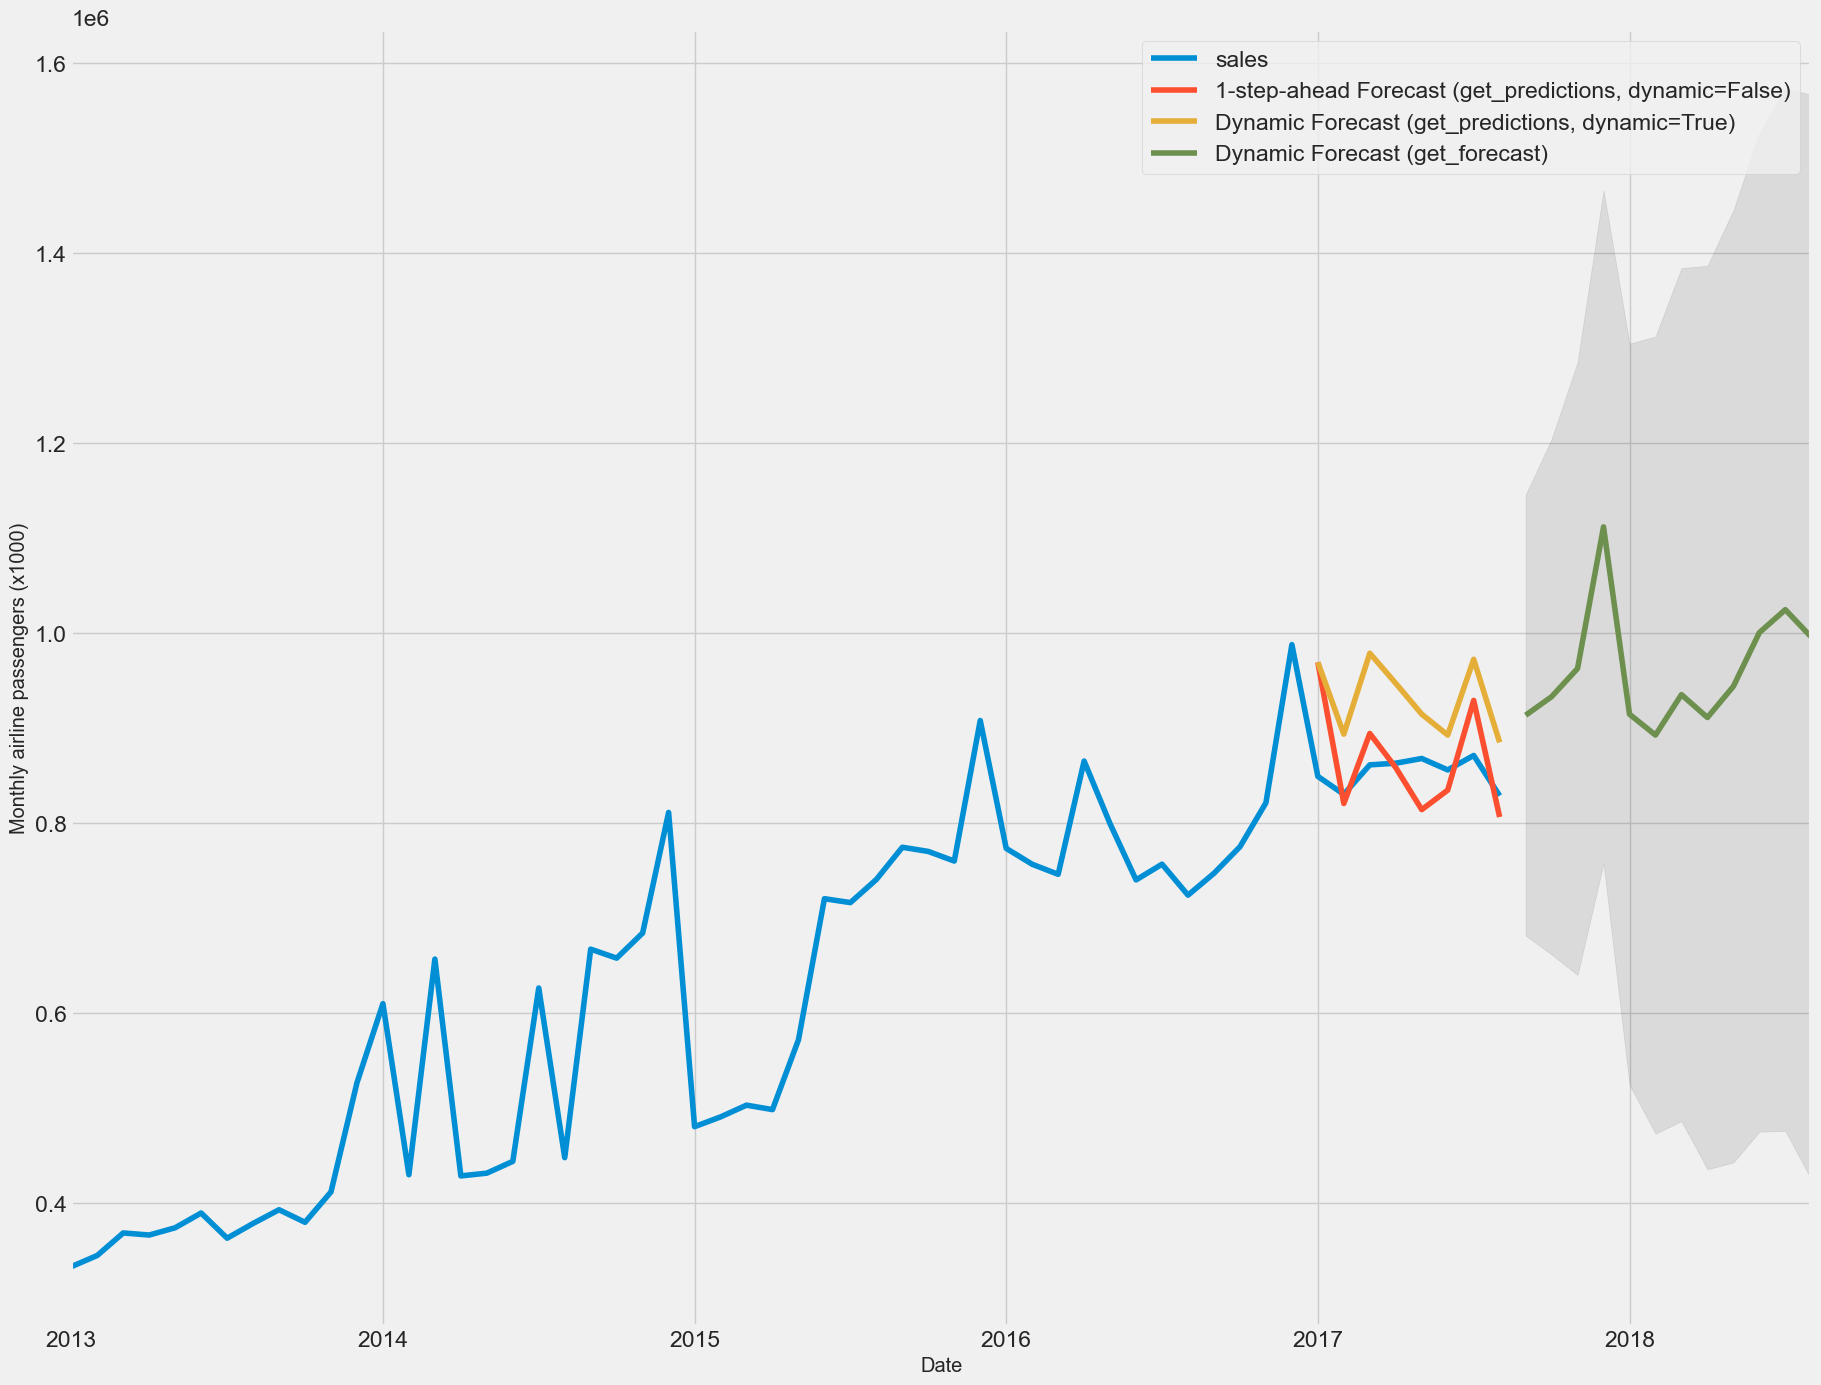

In [19]:
# visualize the prediction
ax = sales_weekly.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\prediction2.png")
plt.show()

In [20]:
y_forecasted = pred0.predicted_mean
y_truth = sales_weekly['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Compute MAPE
mape = np.mean(np.abs(y_forecasted - y_truth) / np.abs(y_truth))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(mape, 2)))

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 2854912236.01
The Mean Absolute Percentage Error of our forecasts is 0.05
The Root Mean Squared Error of our forecasts is 53431.38


## Sale Prediction by Using Supervised Learning

In [31]:
# load dataset
train_data = pd.read_csv(comp_dir / 'train.csv',index_col = False)
test_data = pd.read_csv(comp_dir / 'test.csv')

holiday_data = pd.read_csv(comp_dir / 'holidays_events.csv')
oil_data = pd.read_csv(comp_dir / 'oil.csv')
stores_data = pd.read_csv(comp_dir / 'stores.csv')
trans_data = pd.read_csv(comp_dir / 'transactions.csv')


In [32]:
# load data for Google Colab
# load dataset
#train_data = pd.read_csv('train.csv',index_col = False)
#test_data = pd.read_csv('test.csv')

#holiday_data = pd.read_csv('holidays_events.csv')
#oil_data = pd.read_csv('oil.csv')
#stores_data = pd.read_csv('stores.csv')


In [33]:
store_sales = pd.read_csv(comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze())

In [64]:
#define target
y = store_sales.unstack(['store_nbr', 'family'])

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [66]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# define preprocessing for numerical and categorical data
numerical_features = [col for col in X_train.columns if X_train[col].dtypes in ['int64', 'float64']]
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = [col for col in X_train.columns if X_train[col].dtype in ['object']]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])

#define XGBoost pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', XGBRegressor(n_estimators=100, max_depth=10, random_state=42))])

# fit XGBoost pipeline
xgb_pipeline.fit(X_train, y_train)

In [37]:
# make prediction on test data
y_pred = xgb_pipeline.predict(X_test)

In [38]:
# evaluate the model
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import math

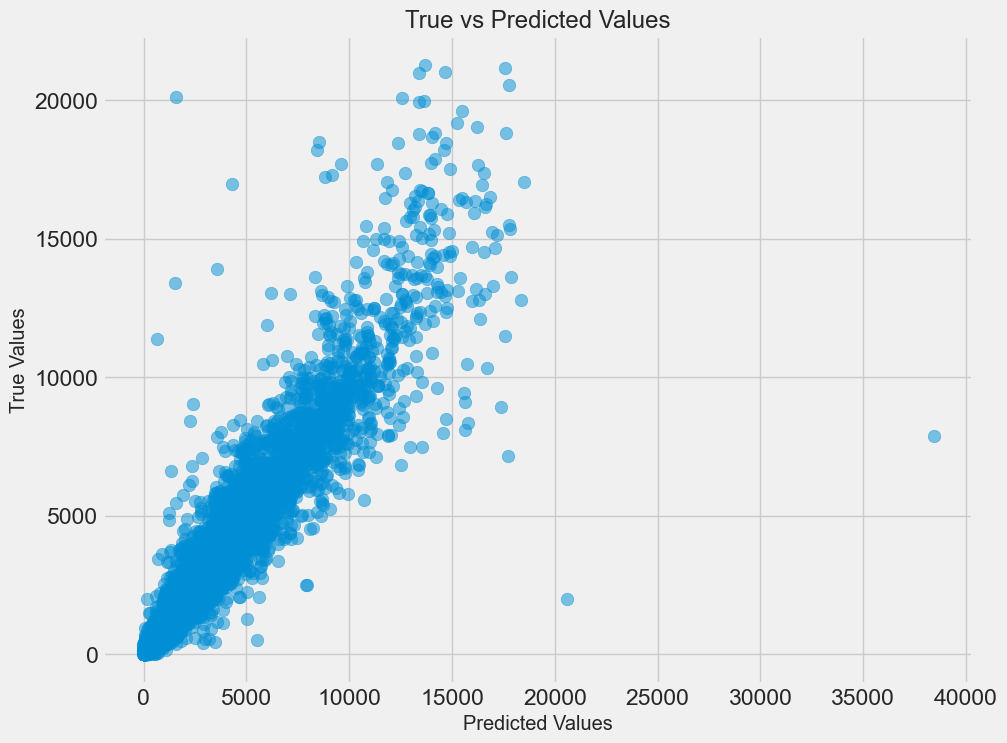

In [61]:
# plot prediction and test data
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_pred, y_test, alpha=0.5)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("True Values")
ax.set_title("True vs Predicted Values")
plt.show()

In [40]:
# evaluate model performance
print("MSE:",mean_squared_error(y_test, y_pred))
print("RMSE:",math.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 60875.579885130865
RMSE: 246.72977097450334
MAPE: 354828436823303.3


In [41]:
#Load test data
test_df = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test_df['date'] = test_df.date.dt.to_period('D')
test_df = test_df.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [48]:
y_submit = pd.DataFrame(xgb_pipeline.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(test_df.id).reindex(columns=['id', 'sales'])
y_submit = y_submit.reset_index()
y_submit.to_csv('D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\submission.csv', index=False)

## Data Processing for Neuro Network

In [ ]:
# set up
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot
from keras.layers import Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [ ]:
train_data = pd.read_csv(comp_dir / 'train.csv',parse_dates =['date'])
test_data = pd.read_csv(comp_dir / 'test.csv',parse_dates =['date'])

In [ ]:
# create an instances for label encoder
le = LabelEncoder()

# using .fit_transform() on categorical data
train_data['family'] = le.fit_transform(train_data['family'])
train_data['store_nbr'] = le.fit_transform(train_data['store_nbr'])

In [ ]:
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,0,0,0.000,0
1,1,2013-01-01,0,1,0.000,0
2,2,2013-01-01,0,2,0.000,0
3,3,2013-01-01,0,3,0.000,0
4,4,2013-01-01,0,4,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,8,28,438.133,0
3000884,3000884,2017-08-15,8,29,154.553,1
3000885,3000885,2017-08-15,8,30,2419.729,148
3000886,3000886,2017-08-15,8,31,121.000,8


In [ ]:
# the start date and end date of the train data
print('Start Date: ', train_data['date'].min())
print('End Date: ', train_data['date'].max())

Start Date:  2013-01-01 00:00:00
End Date:  2017-08-15 00:00:00


In [ ]:
# lag size for the time series
lag_size = (test_data['date'].max().date() - train_data['date'].max().date()).days
print("End date of test data:", test_data['date'].max())
print("Lag size:", lag_size)

End date of test data: 2017-08-31 00:00:00
Lag size: 16


In [ ]:
# transform the data into time series
train_data = train_data[(train_data['date'] >= '2017-01-01')] # working on data starting from 2017
# rearrange the data
train_gp = train_data.sort_values('date').groupby(['family', 'store_nbr','date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales': 'sum'})
train_gp.columns = ['family', 'store_nbr','date','onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [ ]:
# define a function to transform time series data into supervised learning data
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        lag: Number of lag observations as input (X).
        window: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# use the current timestep and the last 29 days to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# drop rows with different item or store values than the shifted columns
last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

In [ ]:
# remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['family', 'store_nbr','onpromotion']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['family', 'store_nbr','onpromotion']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['family(t)', 'store_nbr(t)'], axis=1, inplace=True)

In [ ]:
# split data into train and test
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_test.shape)
X_train.head()

Train set shape (10364, 31)
Validation set shape (2592, 31)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),onpromotion(t),sales(t)
4500,7.0,3.0,12.0,15.0,3.0,7.0,9.0,8.0,2.0,5.0,...,6.0,9.0,21.0,20.0,11.0,4.0,13.0,6.0,0,3.0
9652,4.0,5.0,3.0,2.0,3.0,3.0,2.0,3.0,9.0,9.0,...,4.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,0,0.0
10976,10.0,11.0,8.0,19.0,18.0,11.0,26.0,30.0,15.0,11.0,...,5.0,15.0,16.0,14.0,13.0,20.0,9.0,10.0,0,5.0
5895,7.0,3.0,1.0,3.0,4.0,9.0,0.0,1.0,6.0,5.0,...,5.0,7.0,1.0,4.0,16.0,8.0,1.0,2.0,0,3.0
73389,198.0,187.0,243.0,421.0,237.0,140.0,186.0,144.0,134.0,262.0,...,187.0,229.0,222.0,307.0,176.0,196.0,134.0,174.0,5,149.0


## Convolutional Neural Network Model (CNN)

In [ ]:
# set parameters
epochs = 1000
batch_size = 128
learning_rate = 0.001
adam = optimizers.Adam(lr=learning_rate)

In [ ]:
# reshape for CNN
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Test set shape', X_test_series.shape)


Train set shape (10364, 31, 1)
Test set shape (2592, 31, 1)


In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 30, 128)           384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 1920)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               245888    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                      

In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
cnn_history = cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 13s - loss: 15692.6514 - val_loss: 8553.8730 - 13s/epoch - 41ms/step
Epoch 2/1000
324/324 - 2s - loss: 13498.7324 - val_loss: 22182.4512 - 2s/epoch - 7ms/step
Epoch 3/1000
324/324 - 2s - loss: 11974.3926 - val_loss: 23265.5137 - 2s/epoch - 7ms/step
Epoch 4/1000
324/324 - 2s - loss: 12783.8916 - val_loss: 7574.7661 - 2s/epoch - 6ms/step
Epoch 5/1000
324/324 - 2s - loss: 11274.8965 - val_loss: 11697.5615 - 2s/epoch - 7ms/step
Epoch 6/1000
324/324 - 3s - loss: 10809.1152 - val_loss: 13475.7871 - 3s/epoch - 9ms/step
Epoch 7/1000
324/324 - 3s - loss: 12850.2783 - val_loss: 6955.8521 - 3s/epoch - 8ms/step
Epoch 8/1000
324/324 - 2s - loss: 12059.6152 - val_loss: 5234.7617 - 2s/epoch - 7ms/step
Epoch 9/1000
324/324 - 2s - loss: 11668.0869 - val_loss: 14690.4707 - 2s/epoch - 7ms/step
Epoch 10/1000
324/324 - 2s - loss: 10023.6035 - val_loss: 8698.4570 - 2s/epoch - 7ms/step
Epoch 11/1000
324/324 - 2s - loss: 11162.4502 - val_loss: 11252.6963 - 2s/epoch - 7ms/step
Epoch 12/1

## Long Short-Term Neural Network (LSTM)

In [ ]:
# set parameters
epochs = 1000
batch_size = 128
learning_rate = 0.001
adam = optimizers.Adam(lr=learning_rate)

In [ ]:
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               264192    
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 307,457
Trainable params: 307,457
Non-t

In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
lstm_history = lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 39s - loss: 728253.7500 - val_loss: 36244.1055 - 39s/epoch - 121ms/step
Epoch 2/1000
324/324 - 32s - loss: 894880.0625 - val_loss: 5100279.0000 - 32s/epoch - 97ms/step
Epoch 3/1000
324/324 - 32s - loss: 18369424.0000 - val_loss: 18754.9199 - 32s/epoch - 99ms/step
Epoch 4/1000
324/324 - 33s - loss: 355007.2188 - val_loss: 16731.1250 - 33s/epoch - 102ms/step
Epoch 5/1000
324/324 - 33s - loss: 393707.0938 - val_loss: 32886.7422 - 33s/epoch - 103ms/step
Epoch 6/1000
324/324 - 35s - loss: 25033.5117 - val_loss: 13297.7920 - 35s/epoch - 107ms/step
Epoch 7/1000
324/324 - 35s - loss: 17369.1738 - val_loss: 8378.5645 - 35s/epoch - 107ms/step
Epoch 8/1000
324/324 - 35s - loss: 28959.9629 - val_loss: 11977.4170 - 35s/epoch - 107ms/step
Epoch 9/1000
324/324 - 36s - loss: 11130.1641 - val_loss: 7695.7979 - 36s/epoch - 112ms/step
Epoch 10/1000
324/324 - 36s - loss: 12392.5791 - val_loss: 7897.1997 - 36s/epoch - 112ms/step
Epoch 11/1000
324/324 - 36s - loss: 12801.1895 - val_lo

## CNN-LSTM Model

In [ ]:
# set parameters
epochs = 1000
batch_size = 128
learning_rate = 0.001
adam = optimizers.Adam(lr=learning_rate)

In [ ]:
# reshape data for CNN-LSTM
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_test_series_sub.shape)


Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [ ]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 9s - loss: 10787.7334 - val_loss: 7561.3496 - 9s/epoch - 26ms/step
Epoch 2/1000
324/324 - 5s - loss: 9671.7539 - val_loss: 5337.5015 - 5s/epoch - 14ms/step
Epoch 3/1000
324/324 - 5s - loss: 8129.4521 - val_loss: 6266.0981 - 5s/epoch - 14ms/step
Epoch 4/1000
324/324 - 4s - loss: 8069.8979 - val_loss: 13993.7100 - 4s/epoch - 13ms/step
Epoch 5/1000
324/324 - 4s - loss: 9464.1973 - val_loss: 33702.8008 - 4s/epoch - 13ms/step
Epoch 6/1000
324/324 - 4s - loss: 8861.8105 - val_loss: 5312.0205 - 4s/epoch - 13ms/step
Epoch 7/1000
324/324 - 5s - loss: 7883.0220 - val_loss: 5493.0586 - 5s/epoch - 14ms/step
Epoch 8/1000
324/324 - 5s - loss: 7387.4648 - val_loss: 5899.8794 - 5s/epoch - 15ms/step
Epoch 9/1000
324/324 - 5s - loss: 7280.7085 - val_loss: 7149.8472 - 5s/epoch - 16ms/step
Epoch 10/1000
324/324 - 5s - loss: 7475.2959 - val_loss: 5584.1211 - 5s/epoch - 16ms/step
Epoch 11/1000
324/324 - 5s - loss: 7732.5142 - val_loss: 5218.5146 - 5s/epoch - 15ms/step
Epoch 12/1000
32

## Evaluate Learning Curves

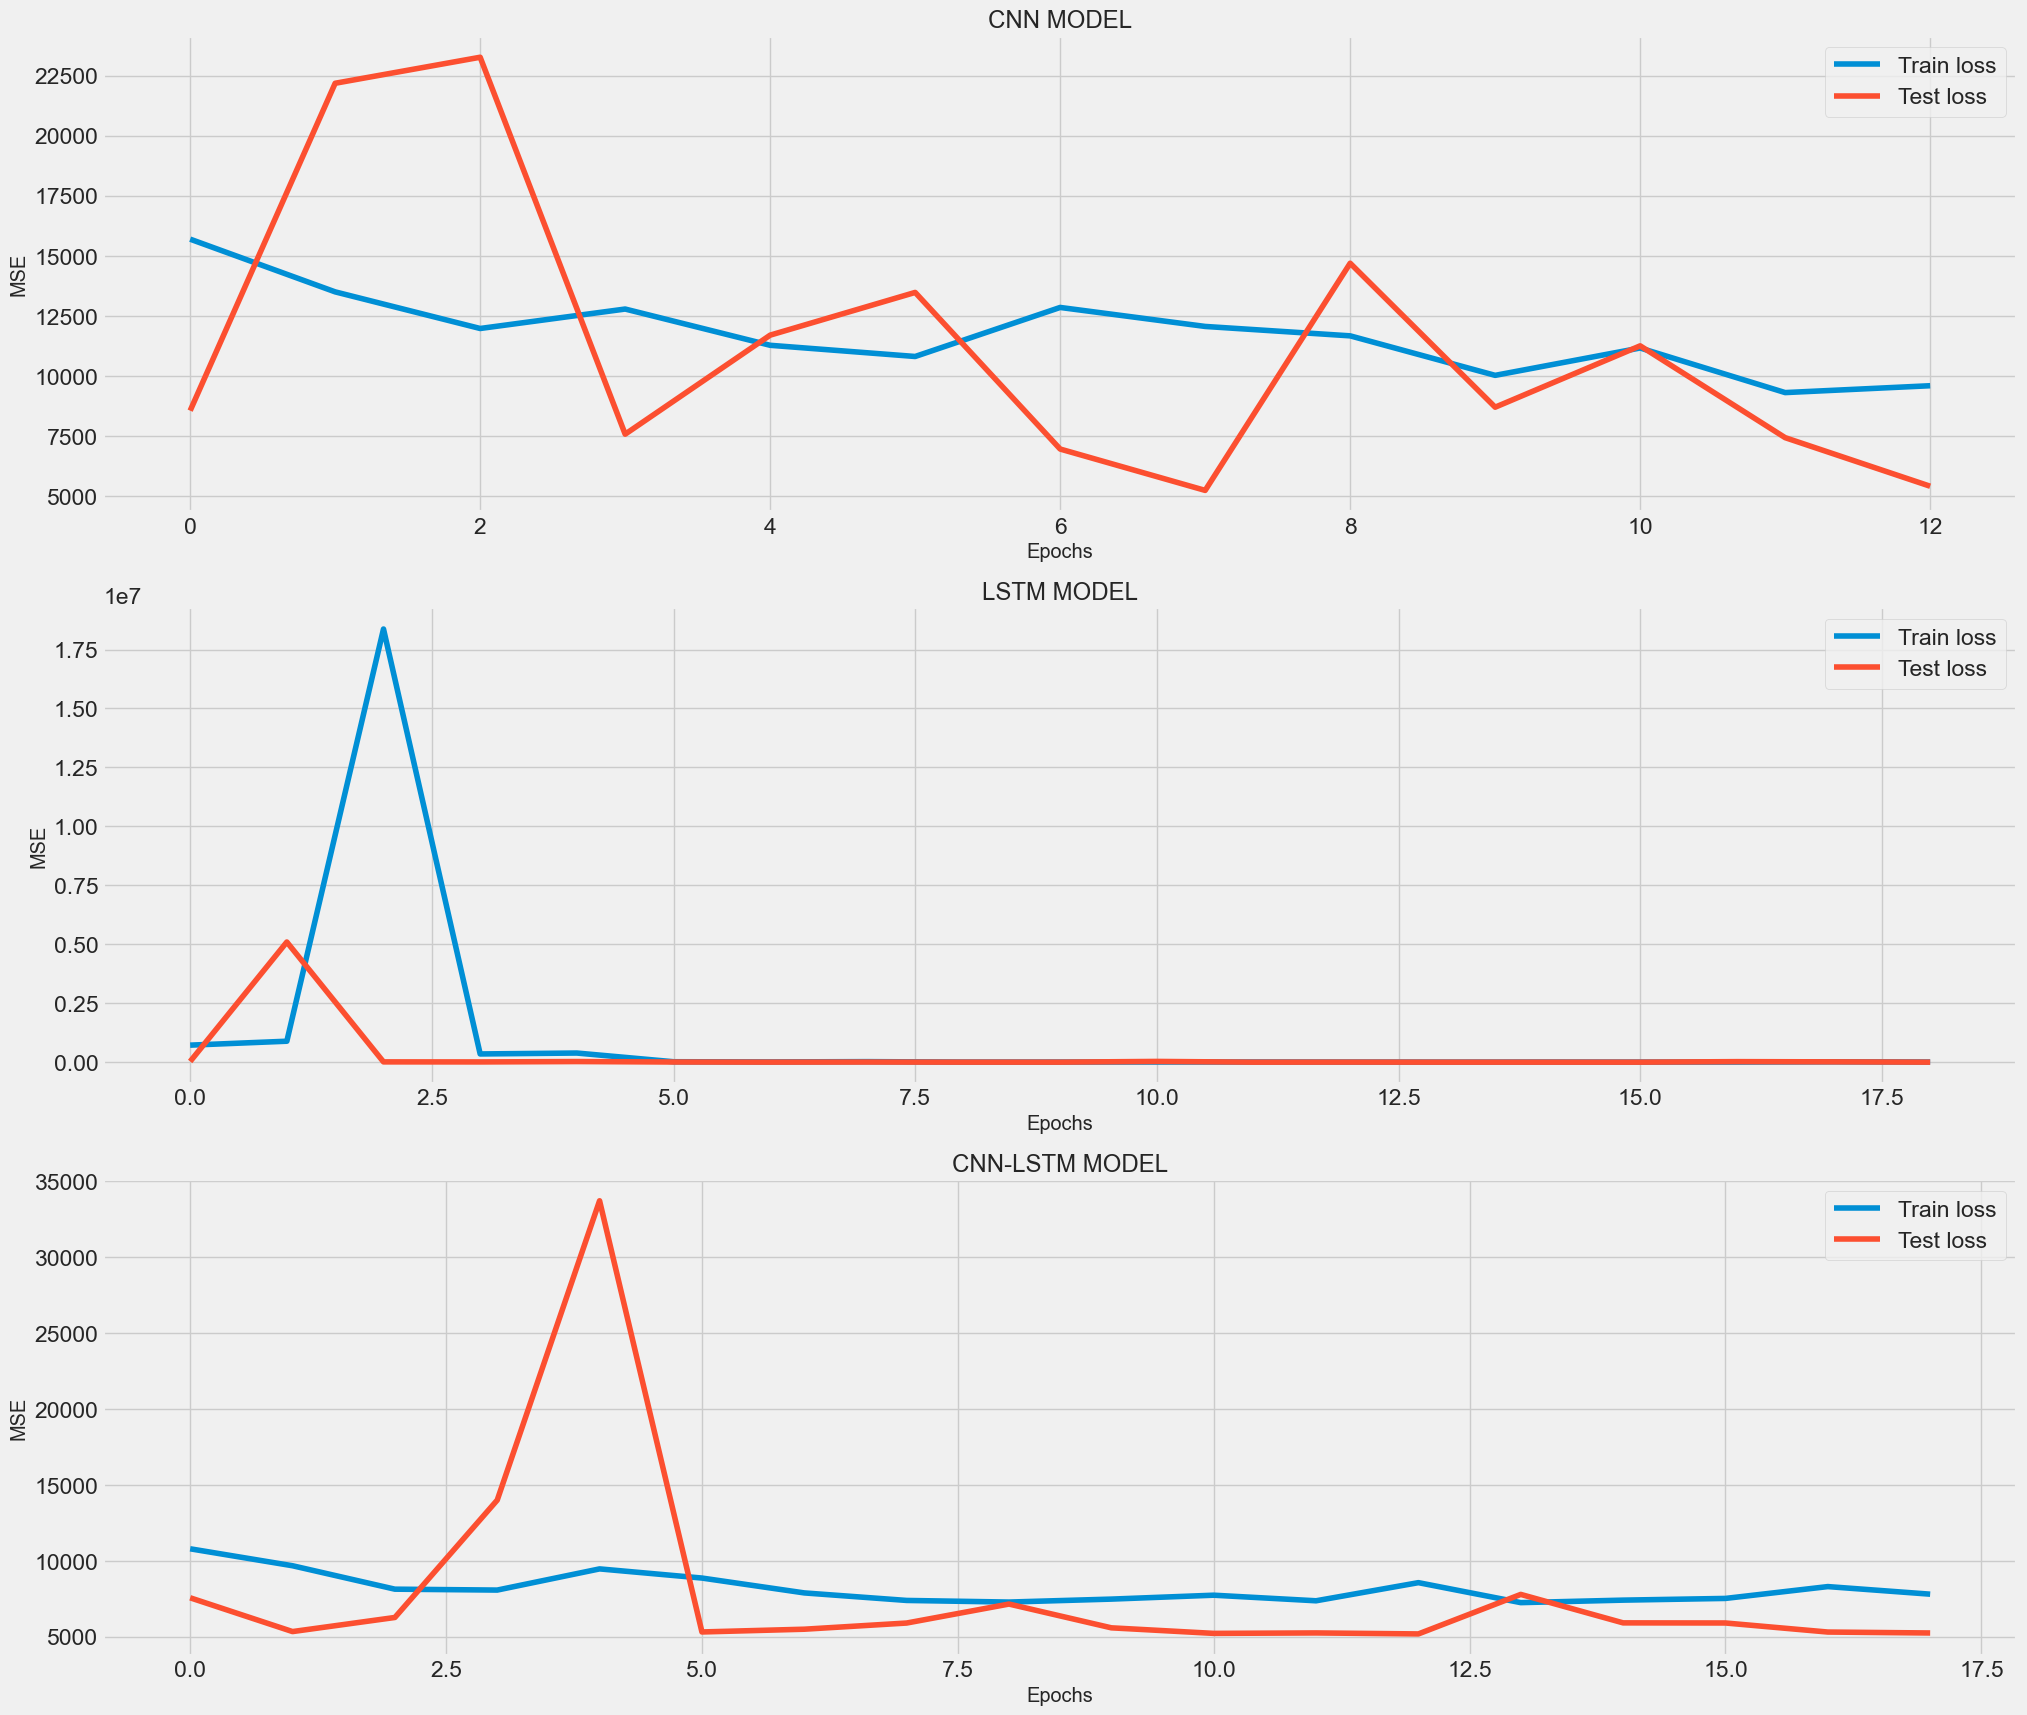

In [ ]:
fig, axes = plt.subplots(3, 1, sharey=False,figsize=(22,20))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Test loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Test loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Test loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\loss.png")
plt.show()

## Evaluate RMSE

In [ ]:
# cnn model
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_test_series)
print('Train CNN rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation CNN rmse:', np.sqrt(mean_squared_error(y_test, cnn_valid_pred)))

81/81 [==============================] - 0s 4ms/step
Train CNN rmse: 80.76074973531514
Validation CNN rmse: 73.5405379152698


In [ ]:
# lstm model
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_test_series)
print('Train LSTM rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation LSTM rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

81/81 [==============================] - 5s 66ms/step
Train LSTM rmse: 100.17298683910136
Validation LSTM rmse: 85.4275524488727


In [ ]:
# cnn-lstm model
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_test_series_sub)
print('Train CNN-LSTM rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation CNN-LSTM rmse:', np.sqrt(mean_squared_error(y_test, cnn_lstm_valid_pred)))

81/81 [==============================] - 1s 7ms/step
Train CNN-LSTM rmse: 83.29612651796344
Validation CNN-LSTM rmse: 72.42351119026709
